In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
from util.general import load_csv_pandas
from util.general import load_csv
from util.executable import get_destination

In [1]:
from util.build_dataset import build_origin_price

origin_p_df, key = build_origin_price(date="201908")

2020-04-08 23:13:58:manager:<INFO> 1 files is loaded from public_data/open_data_raw_material_price/origin/csv/201908.csv in s3 'production-bobsim'


**for target, fix 'retail price'** 

In [2]:
retail_df = origin_p_df[origin_p_df['class']=='소비자가격'].drop('class', axis=1)

In [3]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81737 entries, 0 to 97408
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                81737 non-null  datetime64[ns]
 1   region              81737 non-null  object        
 2   unit_name           81737 non-null  object        
 3   grade               81737 non-null  object        
 4   standard_item_name  81737 non-null  object        
 5   price               81737 non-null  int32         
dtypes: datetime64[ns](1), int32(1), object(4)
memory usage: 4.1+ MB


### null value count

In [8]:
retail_df.isnull().sum()

date                      0
region                    0
unit_name                 0
grade                     0
standard_item_name        0
survey_price_item_name    0
standard_breed_name       0
survey_price_type_name    0
price                     0
dtype: int64

In [125]:
filtered_df["조사단위명"].drop_duplicates(inplace=False)

0          20KG
55          1KG
110        500G
368        100G
438         1포기
746      1KG(단)
813          1개
882         10개
1376    1KG(1단)
1439       600G
2280       200G
3103        2KG
3968        30개
4008         1L
4051        1마리
4085        2마리
4118        5마리
4277       10마리
4318         1속
4507        5KG
Name: 조사단위명, dtype: object

In [129]:
    def get_unit(unit_name):
        # TODO: handle no supported unit_name
        return {
            '20KG': 200, '1.2KG': 12, '8KG': 80, '1KG': 10, '1KG(단)': 10, '1KG(1단)': 10,
            '500G': 5, '200G': 2, '100G': 1, '30개' : 30, '600G' : 6, '5마리' : 5,
            '10마리': 10, '2마리': 2, '1마리': 1, '5KG': 50 , '2KG' : 20 ,
            '10개': 10, '1개': 1,
            '1L': 10,
            '1속': 1,
            '1포기': 1,
        }.get(unit_name, 1) 
    def by_unit( df: pd.DataFrame):
        """
            transform unit
        :return: transformed pd DataFrame
        """
        return df.assign(
            조사단위명=lambda r: r.조사단위명.map(
                lambda x: get_unit(x)
            )
        ).assign(
            당일조사가격=lambda x: x.당일조사가격 / x.조사단위명
        ).drop("조사단위명", axis=1)

In [130]:
retail_converted_df = by_unit(filtered_df)
retail_converted_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81737 entries, 0 to 97408
Data columns (total 11 columns):
조사일자       81737 non-null object
조사구분명      81737 non-null object
표준품목명      81737 non-null object
조사가격품목명    81737 non-null object
표준품종명      81737 non-null object
조사가격품종명    81737 non-null object
조사등급명      81737 non-null object
당일조사가격     81737 non-null float64
조사지역명      81737 non-null object
표준시장명      81737 non-null object
조사가격시장명    81737 non-null object
dtypes: float64(1), object(10)
memory usage: 7.5+ MB


## load cleaned data

In [4]:
from util.build_dataset import build_master, build_origin_price, build_process_price

clean_p, c_key = build_origin_price(date="201908", prefix="clean")
process_p, p_key = build_process_price(date="201908")

2020-04-08 23:35:51:manager:<INFO> 1 files is loaded from public_data/open_data_raw_material_price/origin/csv/201908.csv in s3 'production-bobsim'
2020-04-08 23:35:52:core:<INFO> missing values: 
 None
2020-04-08 23:35:52:manager:<INFO> 1 files is loaded from public_data/open_data_raw_material_price/process/csv/201908.csv in s3 'production-bobsim'


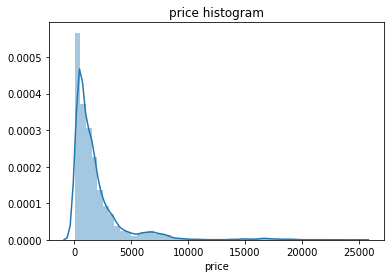

In [2]:
from util.visualize import show_hist
show_hist(clean_p["price"])

In [27]:
from io import StringIO, BytesIO
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import boto3
from util.s3_manager import manager



def save_hist(s: pd.Series, name):
    plt.title('{name}_histogram'.format(name=s.name))
    sns.distplot(s)
    
    save(name=name)
    plt.figure()
    

In [28]:
from io import StringIO, BytesIO
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import boto3
from util.s3_manager import manager

def save(name):
    img_data = BytesIO()
    plt.savefig(img_data, format='png')
    img_data.seek(0)

    s3 = boto3.resource('s3')
    bucket = s3.Bucket("production-bobsim")
    bucket.put_object(Body=img_data, Key="food_material_price_predict_model/{name}_histogram.png".format(name=name))
    
    

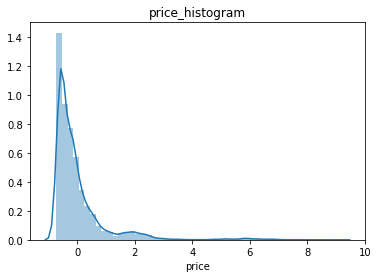

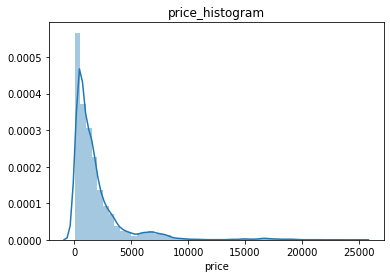

<Figure size 432x288 with 0 Axes>

In [29]:
save_hist(process_p["price"], name="process")
save_hist(clean_p["price"], name="clean")



**Distribution for origin price**

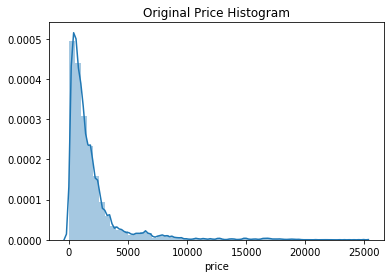

In [139]:
plt.title('Original Price Histogram')
sns.distplot(groupby_df['당일조사가격'].rename("price"))

In [133]:
from scipy.stats import skew
skew(groupby_df['당일조사가격'])

3.6682901187272154

**Distribution for log transformed price**

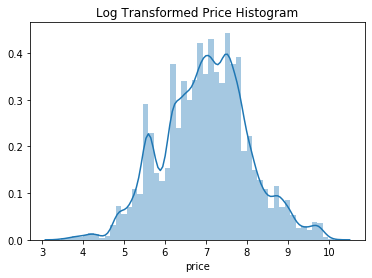

In [140]:
plt.title('Log Transformed Price Histogram')
log_df = np.log1p(groupby_df['당일조사가격'].rename("price"))
sns.distplot(log_df)

In [137]:
skew(log_df)

-0.0055562657484347884

# Compare: numeric value( nomal vs log1p ) // Base skew_values

In [66]:
orgin_df=pd.read_csv('https://production-bobsim.s3.ap-northeast-2.amazonaws.com/public_data/public_price/origin/csv/201908.csv', encoding='euc-kr')

In [67]:
columns = [
            "조사일자", "조사구분명",
            "표준품목명", "조사가격품목명", "표준품종명", "조사가격품종명",
            "조사등급명", "조사단위명", "당일조사가격", "조사지역명"
        ]

In [68]:
filtered_df=orgin_df[columns]

## Check numeric type

In [69]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97414 entries, 0 to 97413
Data columns (total 10 columns):
조사일자       97414 non-null object
조사구분명      97414 non-null object
표준품목명      97414 non-null object
조사가격품목명    97414 non-null object
표준품종명      97414 non-null object
조사가격품종명    97414 non-null object
조사등급명      97414 non-null object
조사단위명      97414 non-null object
당일조사가격     97414 non-null int64
조사지역명      97414 non-null object
dtypes: int64(1), object(9)
memory usage: 7.4+ MB


### hist using displot

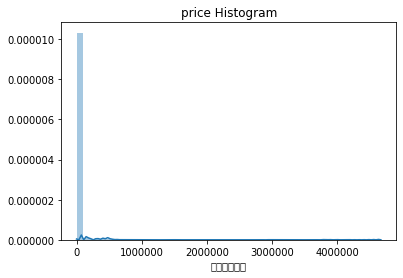

In [70]:
# see distribution of numecric type 
plt.title('price Histogram')
sns.distplot(data_df['당일조사가격'])


In [71]:
# check skew 
from scipy.stats import skew
features_index = filtered_df.dtypes[filtered_df.dtypes != 'object'].index

# house_df에 컬럼 index를 [ ]로 입력하면 해당하는 컬럼 데이터 셋 반환. apply lambda로 skew( )호출 
skew_features = filtered_df[features_index].apply(lambda x : skew(x))

# skew 정도가 1 이상인 컬럼들만 추출. 
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

당일조사가격    13.296264
dtype: float64


## 로그변환

In [72]:
filtered_df[skew_features_top.index] = np.log1p(filtered_df[skew_features_top.index])

C:\Users\park\Anaconda3\lib\site-packages\pandas\core\frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


## 분포도 확인 ( 결정한 이유 )

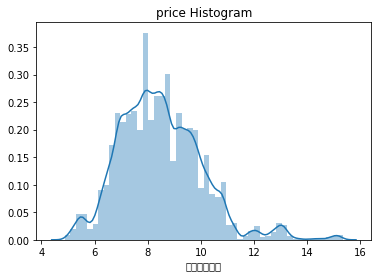

In [73]:
# see distribution of numecric type 
plt.title('price Histogram')
sns.distplot(filtered_df['당일조사가격'])

In [74]:
skew(filtered_df['당일조사가격'])

0.7655006976533527

### datetime 타입에서 년, 월, 일, 시간 추출


In [75]:
filtered_df['조사일자'] = filtered_df.조사일자.apply(pd.to_datetime)

C:\Users\park\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [76]:
filtered_df['year']= filtered_df.조사일자.apply(lambda x : x.year)
filtered_df['month']=filtered_df.조사일자.apply(lambda x : x.month)
filtered_df['day']=filtered_df.조사일자.apply(lambda x: x.day)

C:\Users\park\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\park\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\park\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [77]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97414 entries, 0 to 97413
Data columns (total 13 columns):
조사일자       97414 non-null datetime64[ns]
조사구분명      97414 non-null object
표준품목명      97414 non-null object
조사가격품목명    97414 non-null object
표준품종명      97414 non-null object
조사가격품종명    97414 non-null object
조사등급명      97414 non-null object
조사단위명      97414 non-null object
당일조사가격     97414 non-null float64
조사지역명      97414 non-null object
year       97414 non-null int64
month      97414 non-null int64
day        97414 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(3), object(8)
memory usage: 9.7+ MB


In [78]:
temp1=pd.read_csv('https://production-bobsim.s3.ap-northeast-2.amazonaws.com/public_data/public_price/origin/csv/201908.csv', encoding='euc-kr')
columns = [
            "조사일자", "조사구분명",
            "표준품목명", "조사가격품목명", "표준품종명", "조사가격품종명",
            "조사등급명", "조사단위명", "당일조사가격", "조사지역명"
        ]

In [103]:
def unit_fit(unit_name):
    unit=0
    if unit_name=='20KG' : unit= 200
    elif unit_name=='1.2KG' : unit= 12
    elif unit_name=='8KG' : unit= 80
    elif unit_name=='1KG' : unit=10
    elif unit_name=='1KG(단)' : unit=10
    elif unit_name=='1KG(1단)': unit=10
    elif unit_name=='10개': unit=10
    elif unit_name=='10마리': unit=10
    elif unit_name=='1L' : unit=10 
    elif unit_name=='100G': unit= 1
    elif unit_name=='1개' : unit= 1
    elif unit_name=='1마리' : unit= 1
    elif unit_name=='1속' : unit= 1
    elif unit_name=='1포기' : unit= 1
    elif unit_name=='200G' :unit=2
    elif unit_name=='2마리' : unit= 2
    elif unit_name=='500G' : unit= 5
    else: unit = 6
    
    return unit

In [105]:
temp2=temp1[temp1['조사구분명']=='소비자가격']
temp2 =temp2[['조사일자', '조사가격품목명','표준품종명','조사가격품종명','표준품목명','조사지역명','조사단위명','당일조사가격']]


In [106]:
temp2['price_unit']= temp2['조사단위명'].apply(lambda x : unit_fit(x))
temp2['averge_price']= temp2['당일조사가격']/temp2['price_unit']

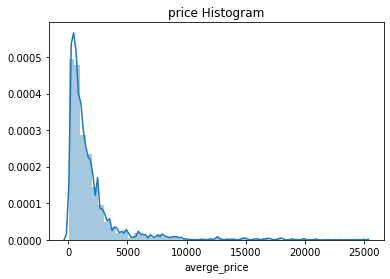

In [107]:
# see distribution of numecric type 
plt.title('price Histogram')
sns.distplot(temp2['averge_price'])

In [108]:
skew(temp2['averge_price']) # 소비자가격 skew

3.8459733534846507

In [84]:
skew(temp1['당일조사가격']) # 모든가격 skew

13.296264438735514

In [85]:
temp2['averge_price'] = np.log1p(temp2['averge_price'])
print('로그변화 후 skew 값')
skew(temp2['averge_price'])

로그변화 후 skew 값


0.12372746170184191

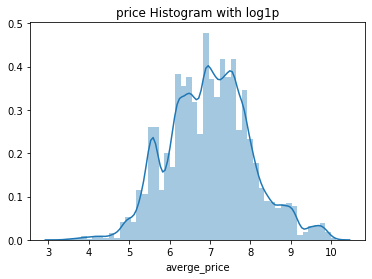

In [86]:
plt.title('price Histogram with log1p')
sns.distplot(temp2['averge_price'])